In [1]:
import librosa
from scipy.io.wavfile import read as read_wav
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import time
import copy
import numpy as np

In [6]:
import scipy.io.wavfile
sr,_ = scipy.io.wavfile.read("./audio_data_SAVEE/DC/a01.wav")

In [7]:
print(sr)

44100


In [4]:
# Test
#sampling_rate, data=read_wav("Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-02-01.wav")
directory = "./audio_data/train/"
actor_number = "DC"
file = "a15.wav"
y, _ = librosa.load(directory+actor_number+'/'+file, sr = 44100, offset=0, duration=3)
S = librosa.feature.melspectrogram(y=y, sr=44100, n_mels=128, fmax=8000)
feature = librosa.feature.mfcc(S=librosa.power_to_db(S))

# feature_new = np.empty((0, 259))
# for i in range(feature.shape[0]):
#     temp = np.concatenate([feature[i], np.zeros(259-feature.shape[1])])
#     feature_new = np.append(feature_new, [temp], axis = 0)


feature.shape

(20, 259)

In [2]:
# directory = "./Audio_Speech_Actors_01-24/Actor_01/"
def combination(directory):
    features = []
    labels = []
    
    for actor_number in os.listdir(directory):
        if len(actor_number) == 2:
            count = 0
            for file in os.listdir(directory+actor_number):
                # load the wavefiles
                y, _ = librosa.load(directory+actor_number+'/'+file, sr = 44100, offset = 0, duration=3)
                S = librosa.feature.melspectrogram(y=y, sr=44100, n_mels=128, fmax=8000)
                feature = librosa.feature.mfcc(S=librosa.power_to_db(S))

                # truncate or zero-pad the signal 259->282
                feature_new = np.empty((0, 282))
                for i in range(feature.shape[0]):
                    temp = np.concatenate([feature[i], np.zeros(282-feature.shape[1])])
                    feature_new = np.append(feature_new, [temp], axis = 0)


                if count//15 == 4 or count//15 == 5:
                    label = 4 #"neutral"
                elif count//15 == 3:
                    label = 3 #"happy"
                elif count//15 == 6:
                    label = 5 #"sad"
                elif count//15 == 0:
                    label = 0 #"angry"
                elif count//15 == 2:
                    label = 2 #"fearful"
                elif count//15 == 1:
                    label = 1 #"disgust"
                elif count//15 == 7:
                    label = 6 #"surprised" 

                count += 1
                features.append(feature_new)
                labels.append(label)
        else:
            for file in os.listdir(directory+actor_number):
                # load the wavefiles
                y, _ = librosa.load(directory+actor_number+'/'+file, sr=48000, offset = 0, duration=3)
                S = librosa.feature.melspectrogram(y=y, sr=48000, n_mels=128, fmax=8000)
                feature = librosa.feature.mfcc(S=librosa.power_to_db(S))

                # truncate or zero-pad the signal
                feature_new = np.empty((0, 282))
                for i in range(feature.shape[0]):
                    temp = np.concatenate([feature[i], np.zeros(282-feature.shape[1])])
                    feature_new = np.append(feature_new, [temp], axis = 0)

                number = file.split("-")
                emotion = number[2]
                #if emotion == "01" or emotion == "02":
                if emotion =="01":
                    continue
                if emotion == "02":
                    label = 4 #"neutral"
                elif emotion == "03":
                    label = 3 #"happy"
                elif emotion == "04":
                    label = 5 #"sad"
                elif emotion == "05":
                    label = 0 #"angry"
                elif emotion == "06":
                    label = 2 #"fearful"
                elif emotion == "07":
                    label = 1 #"disgust"
                elif emotion == "08":
                    label = 6 #"surprised" 

                features.append(feature_new)
                labels.append(label)
        
    return features, labels


In [3]:
class MFCC(Dataset):
    """MFCC from the audio."""

    def __init__(self, directory, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.directory = directory
        self.features, self.labels = combination(directory)
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        sample = {'mfcc': feature, 'label': label}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [16]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        mfcc, label = sample['mfcc'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        mfcc_tensor = torch.from_numpy(mfcc)
        mfcc_tensor = mfcc_tensor.unsqueeze(0)
        #mfcc = mfcc.transpose((2, 0, 1))
        return {'mfcc': mfcc_tensor.double(),
                'label': torch.tensor(label).double()}

In [17]:
# prepare the form of the audio and load it into pytorch
dataset_train = MFCC(directory = "./audio_data/train/",
                                           transform=transforms.Compose([
                                               ToTensor()
                                           ]))

dataset_valid = MFCC(directory = "./audio_data/valid/",
                                           transform=transforms.Compose([
                                               ToTensor()
                                           ]))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4,
                        shuffle=True, num_workers=0)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=4,
                        shuffle=True, num_workers=0)
dataloaders = {'train': dataloader_train, 'valid': dataloader_valid}

In [18]:
dataset_size_train = len(dataset_train)
dataset_size_valid = len(dataset_valid)
dataset_sizes = {'train': dataset_size_train, 'valid': dataset_size_valid}

In [12]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_loss_list = []
    epoch_acc_list = []
    
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample_batched in dataloaders[phase]:
                inputs = sample_batched['mfcc']
                labels = sample_batched['label']
                inputs = inputs.to(device)
                labels = labels.long().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                #print(labels)
                #print(preds)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            epoch_loss_list.append(round(epoch_loss,4))
            epoch_acc_list.append(round(epoch_acc.item(),4))
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        if epoch % 10 == 0:
            model.load_state_dict(best_model_wts)
            PATH = "./model_audio_CNN{}.pth".format(epoch)
            torch.save(model.state_dict(), PATH)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_list, epoch_acc_list

In [19]:
device = torch.device("cuda")

In [20]:
class Net(nn.Module):            
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 7),
            nn.Softmax(dim = 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

net = Net()
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5

In [10]:
model = net.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# the unfreezed parameter are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model, loss_list, acc_list = train_model(model, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.9458 Acc: 0.1509
valid Loss: 1.9405 Acc: 0.1429

Epoch 2/50
----------
train Loss: 1.9445 Acc: 0.1402
valid Loss: 1.9413 Acc: 0.2321

Epoch 3/50
----------
train Loss: 1.9397 Acc: 0.1696
valid Loss: 1.9243 Acc: 0.1830

Epoch 4/50
----------
train Loss: 1.9216 Acc: 0.2036
valid Loss: 1.8958 Acc: 0.2321

Epoch 5/50
----------
train Loss: 1.9065 Acc: 0.2277
valid Loss: 1.9806 Acc: 0.1696

Epoch 6/50
----------
train Loss: 1.9068 Acc: 0.2286
valid Loss: 1.8614 Acc: 0.2946

Epoch 7/50
----------
train Loss: 1.8308 Acc: 0.3107
valid Loss: 1.7617 Acc: 0.3884

Epoch 8/50
----------
train Loss: 1.8013 Acc: 0.3545
valid Loss: 1.7415 Acc: 0.4107

Epoch 9/50
----------
train Loss: 1.7995 Acc: 0.3446
valid Loss: 1.7250 Acc: 0.4330

Epoch 10/50
----------
train Loss: 1.7836 Acc: 0.3705
valid Loss: 1.7589 Acc: 0.3929

Epoch 11/50
----------
train Loss: 1.7912 Acc: 0.3607
valid Loss: 1.7338 Acc: 0.4286

Epoch 12/50
----------
train Loss: 1.7933 Acc: 0.3473
valid Los

In [14]:
filepath = "./audio_CNN_acc.txt"
import json
with open(filepath, 'w') as f:
    f.write(json.dumps(acc_list))

In [15]:
filepath = "./audio_CNN_loss.txt"
import json
with open(filepath, 'w') as f:
    f.write(json.dumps(loss_list))

In [21]:
model = net
model.load_state_dict(torch.load("./model_audio_CNN50.pth"))
model = model.cuda()

In [22]:
def test_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    right = 0
    confusion_matrix = np.zeros((7,7))
    #fig = plt.figure()
    
    # Speed up the computation
    with torch.no_grad():
        for sample_batched in dataloaders["train"]:
            inputs = sample_batched['mfcc']
            labels = sample_batched['label']
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                #ax = plt.subplot(num_images//3, 3, images_so_far)
                #ax.axis('off')
                #ax.set_title('predicted: {}, label: {}'.format(class_names[preds[j]],class_names[labels[j]] ))
                #imshow(inputs.cpu().data[j])
                
                if preds[j] == labels[j]:
                    right += 1
                
                confusion_matrix[preds[j]][labels[j]] = confusion_matrix[preds[j]][labels[j]]+1
                
                #print('predicted: {}, label: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                #print(confusion_matrix)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    accuracy = right/num_images
                    print("Prediction Accuracy: {}%".format(accuracy*100))
                    #print(type(confusion_matrix))
                    return confusion_matrix
        model.train(mode=was_training)

In [27]:
confusion_matrix = test_model(model,num_images = 1000)

Prediction Accuracy: 37.5%


In [28]:
print(confusion_matrix)

[[ 55.   6.  20.  27.   0.  18.   8.]
 [ 23.  66.   6.  13.  13.  16.  14.]
 [ 12.   0.  30.  20.   0.   1.  13.]
 [ 16.   5.  14.  23.   2.   6.  13.]
 [  8.  59.  28.  18. 129.  76.  23.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [ 20.   4.  47.  49.   2.  25.  72.]]


In [29]:
confusion_sum = np.sum(confusion_matrix, axis = 1)
for i in range(7):
    for j in range(7):
        if confusion_sum[i] == 0:
            confusion_matrix[i][j] = 0
        else:
            confusion_matrix[i][j] = confusion_matrix[i][j]/confusion_sum[i]
        
        
        

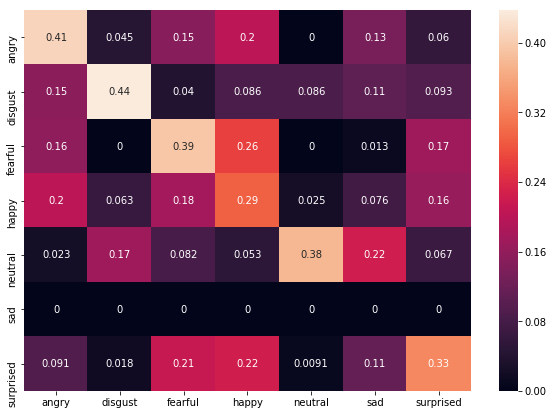

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
class_names = ["angry","disgust","fearful","happy","neutral","sad","surprised"]
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## LSTM Model

In [4]:
# a 1 layer LSTM
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.hidden_unit = 128  # number of hidden units
        
        # input layer
        self.lstm_layer = nn.LSTM(input_size=20,
                                  hidden_size=self.hidden_unit,
                                  num_layers=2,
                                  batch_first=True,
                                  dropout = 0.2,
                                  bidirectional=False)
        
        self.output_linear = nn.Sequential(nn.Linear(self.hidden_unit, 7),nn.Softmax(dim = 1))
        
    # the function for the forward pass of network (i.e. from input to output)
    def forward(self, input):
        # note that LSTM in Pytorch requires input shape as (batch, seq, feature)
        # so we need to reshape the input
        
        batch_size = input.size(0)
        mfcc = input.size(1)
        num_frame = input.size(2)
        
        input = input.transpose(1, 2).contiguous()  # (batch, time, freq)
        #print(input.size())
        
        # pass it through layers
        output, (h_n, c_n) = self.lstm_layer(input)  # (batch, time, hidden) # output[:,-1,:] = h_n[-1], they are all the last hidden state
        #print(output[:,-1,:])
        #print(h_n[-1])
        #output = output.contiguous().view(batch_size*num_frame, -1)  # (batch*time, freq)
        #output = self.output_linear(h_n[-1])
        output = self.output_linear(output[:,-1,:])
        
        # reshape back
        #output = output.view(batch_size, num_frame, 7)
        #output = output.transpose(1, 2).contiguous()  # (batch_size, freq, time)
        
        return output
    
# the model and the optimizers
model_LSTM = LSTM()
print(model_LSTM)


# define the optimizer
#optimizer = optim.Adam(model_LSTM.parameters(), lr=args.lr)
#scheduler  = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
#scheduler.step()

LSTM(
  (lstm_layer): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.2)
  (output_linear): Sequential(
    (0): Linear(in_features=128, out_features=7, bias=True)
    (1): Softmax()
  )
)


In [5]:
class ToTensor_LSTM(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        mfcc, label = sample['mfcc'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        mfcc_tensor = torch.from_numpy(mfcc)
        #mfcc_tensor = mfcc_tensor.unsqueeze(0)
        #mfcc = mfcc.transpose((2, 0, 1))
        return {'mfcc': mfcc_tensor.double(),
                'label': torch.tensor(label).double()}

In [6]:
# prepare the form of the audio and load it into pytorch
dataset_train_LSTM = MFCC(directory = "./audio_data/train/",
                                           transform=transforms.Compose([
                                               ToTensor_LSTM()
                                           ]))

dataset_valid_LSTM = MFCC(directory = "./audio_data/valid/",
                                           transform=transforms.Compose([
                                               ToTensor_LSTM()
                                           ]))
dataloader_train_LSTM = torch.utils.data.DataLoader(dataset_train_LSTM, batch_size=4,
                        shuffle=True, num_workers=0)
dataloader_valid_LSTM = torch.utils.data.DataLoader(dataset_valid_LSTM, batch_size=4,
                        shuffle=True, num_workers=0)

In [7]:
dataloaders_LSTM = {'train': dataloader_train_LSTM, 'valid': dataloader_valid_LSTM}

In [8]:
dataset_size_train_LSTM = len(dataset_train_LSTM)
dataset_size_valid_LSTM = len(dataset_valid_LSTM)
dataset_sizes_LSTM = {'train': dataset_size_train_LSTM, 'valid': dataset_size_valid_LSTM}

In [32]:
def train_model_LSTM(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_loss_list = []
    epoch_acc_list = []
    
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample_batched in dataloaders[phase]:
                inputs = sample_batched['mfcc']
                labels = sample_batched['label']
                inputs = inputs.to(device)
                labels = labels.long().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    preds = torch.argmax(outputs, 1)
                    #print(outputs)
                    #print(preds)
                    #print(labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                #print(labels)
                #print(preds)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes_LSTM[phase]
            epoch_acc = running_corrects.double() / dataset_sizes_LSTM[phase]

            epoch_loss_list.append(round(epoch_loss,4))
            epoch_acc_list.append(round(epoch_acc.item(),4))
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        if epoch % 10 == 0:
            model.load_state_dict(best_model_wts)
            PATH = "./model_audio_LSTM{}.pth".format(epoch)
            torch.save(model.state_dict(), PATH)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_list, epoch_acc_list

In [12]:
device = torch.device("cuda")

In [34]:
model_LSTM = model_LSTM.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_LSTM.parameters(), lr=0.001, momentum=0.9)
# the unfreezed parameter are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [35]:
model_LSTM, loss_list_LSTM, acc_list_LSTM = train_model_LSTM(model_LSTM, dataloaders_LSTM, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 1/50
----------
train Loss: 1.9457 Acc: 0.1750
valid Loss: 1.9449 Acc: 0.2366

Epoch 2/50
----------
train Loss: 1.9446 Acc: 0.2143
valid Loss: 1.9436 Acc: 0.2768

Epoch 3/50
----------
train Loss: 1.9438 Acc: 0.2152
valid Loss: 1.9426 Acc: 0.2589

Epoch 4/50
----------
train Loss: 1.9428 Acc: 0.2446
valid Loss: 1.9416 Acc: 0.2232

Epoch 5/50
----------
train Loss: 1.9418 Acc: 0.2536
valid Loss: 1.9408 Acc: 0.2634

Epoch 6/50
----------
train Loss: 1.9406 Acc: 0.2679
valid Loss: 1.9393 Acc: 0.2634

Epoch 7/50
----------
train Loss: 1.9389 Acc: 0.2875
valid Loss: 1.9391 Acc: 0.2232

Epoch 8/50
----------
train Loss: 1.9376 Acc: 0.2812
valid Loss: 1.9382 Acc: 0.2455

Epoch 9/50
----------
train Loss: 1.9372 Acc: 0.2839
valid Loss: 1.9379 Acc: 0.2455

Epoch 10/50
----------
train Loss: 1.9371 Acc: 0.2920
valid Loss: 1.9377 Acc: 0.2500

Epoch 11/50
----------
train Loss: 1.9439 Acc: 0.2312
valid Loss: 1.9435 Acc: 0.2768

Epoch 12/50
----------
train Loss: 1.9436 Acc: 0.2277
valid Los

In [36]:
filepath = "./audio_LSTM_acc.txt"
import json
with open(filepath, 'w') as f:
    f.write(json.dumps(acc_list_LSTM))

In [37]:
filepath = "./audio_LSTM_loss.txt"
import json
with open(filepath, 'w') as f:
    f.write(json.dumps(loss_list_LSTM))

In [9]:
model_LSTM.load_state_dict(torch.load("./model_audio_LSTM50.pth"))
model_LSTM = model_LSTM.cuda()

In [13]:
def test_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    right = 0
    confusion_matrix = np.zeros((7,7))
    #fig = plt.figure()
    
    # Speed up the computation
    with torch.no_grad():
        for sample_batched in dataloaders_LSTM["train"]:
            inputs = sample_batched['mfcc']
            labels = sample_batched['label']
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                #ax = plt.subplot(num_images//3, 3, images_so_far)
                #ax.axis('off')
                #ax.set_title('predicted: {}, label: {}'.format(class_names[preds[j]],class_names[labels[j]] ))
                #imshow(inputs.cpu().data[j])
                
                if preds[j] == labels[j]:
                    right += 1
                
                confusion_matrix[preds[j]][labels[j]] = confusion_matrix[preds[j]][labels[j]]+1
                
                #print('predicted: {}, label: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                #print(confusion_matrix)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    accuracy = right/num_images
                    print("Prediction Accuracy: {}%".format(accuracy*100))
                    #print(type(confusion_matrix))
                    return confusion_matrix
        model.train(mode=was_training)

In [14]:
confusion_matrix = test_model(model_LSTM,num_images = 1000)

Prediction Accuracy: 24.8%


In [15]:
print(confusion_matrix)

[[ 35.  28.   6.   9.   1.   5.   5.]
 [  2.   0.   0.   0.   0.   0.   0.]
 [ 67.  46. 118.  94.  42.  84. 112.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [ 33.  74.  22.  39.  95.  55.  27.]
 [  0.   0.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]]


In [71]:
np.sum(confusion_matrix)

1000.0

In [52]:
confusion_sum = np.sum(confusion_matrix, axis = 1)
for i in range(7):
    for j in range(7):
        confusion_matrix[i][j] = confusion_matrix[i][j]/confusion_sum[i]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [54]:
print(confusion_matrix)

[[0.4137931  0.29885057 0.05747126 0.11494253 0.01149425 0.05747126
  0.04597701]
 [1.         0.         0.         0.         0.         0.
  0.        ]
 [0.12633452 0.06939502 0.20818505 0.17437722 0.07829181 0.13701068
  0.20640569]
 [       nan        nan        nan        nan        nan        nan
         nan]
 [0.10601719 0.21203438 0.06303725 0.10315186 0.28939828 0.16045845
  0.06590258]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [       nan        nan        nan        nan        nan        nan
         nan]]


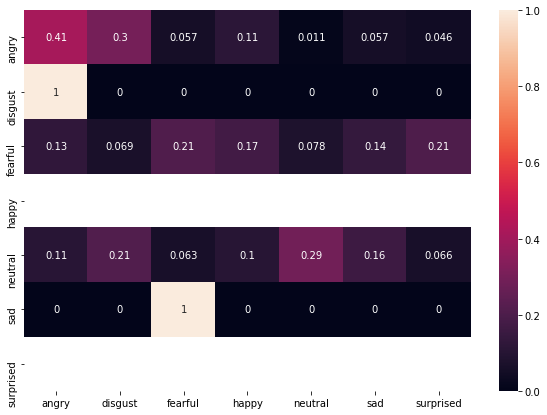

In [53]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
class_names = ["angry","disgust","fearful","happy","neutral","sad","surprised"]
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)